In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from model import *

In [2]:
#paramaters for SIMULATION

vaultToken = 'USDC'
secondaryToken = 'FTM'

#LP Size 
volume1 =  2000000 #amount of vaultToken in LP
volume2 =  volume1*5 #amount of secondary token in LP

# VAULT INFO
vaultTVL = 100 # amount of vault Token in LP 
lendAllocation = .65
#debt thresholds for rebalancing
debtLow = .97
debtHigh = 1.03
collatLow = .5
collatTarget = .55
collatHigh = .6
harvestTreshold = 1
rebalanceAdj = .996 #when rebalancing losses from swapping 

# APY's
lendRate = .05
borrowRate = .03
farmRate = .35

#SIM INFO
stepsPerYear = 365*24*30 #if simulating hourly set to be 365 * 24 

annualRates = {'lend' : lendRate, 'borrow' : borrowRate, 'farm' : farmRate}
adjRates = {'lend' : ((1 + lendRate)**(1/stepsPerYear) - 1), 
            'borrow' : ((1 + borrowRate)**(1/stepsPerYear) - 1),
            'farm' : ((1 + farmRate)**(1/stepsPerYear) - 1)}

nSteps = int(stepsPerYear / 365)


In [16]:
#extereme price movements over 24h example 

nSteps = int(stepsPerYear / 365)
pLow = .2; pHigh = 1 - pLow
nSims = 100
expScale = 300
pBuy = pLow
pIncr = (pHigh - pLow) / nSims

apyLog = []
priceRangeLog = []
priceChangeLog = []
drawdownLog = []
lpValueLog = []
hodlValueLog = []
vaultValueLog = []
lpRet = (1 + farmRate)**(nSteps/stepsPerYear) - 1


lpPerc = 0.5*(vaultTVL / volume1)

for j in range(nSims) :     
    allTrades = genSimulatedTrades()

    vol1, vol2, lp, vaultInitial = setInitialValues()
    vaultLog, priceLog, debtRatioLog, collatRatioLog, vol1, vol2 = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                                secondaryToken, vol1, vol2, adjRates)    
    apy, drawdown = simStats(vaultTVL, vaultLog)
    apyLog.append(apy)
    drawdownLog.append(drawdown)
    lpValueLog.append((1+lpRet)*getLpValue(vol1,lpPerc))
    prices = getPrices(vaultToken, secondaryToken, vol1, vol2)
    hodlValue = lpPerc*(volume1 + volume2*prices[secondaryToken])
    hodlValueLog.append(hodlValue)
    vaultValueLog.append(vaultLog[-1])
    

    priceRangeLog.append(max(priceLog) / min(priceLog) - 1)
    priceChangeLog.append(priceLog[-1] / priceLog[0] - 1)
    pBuy += pIncr
    


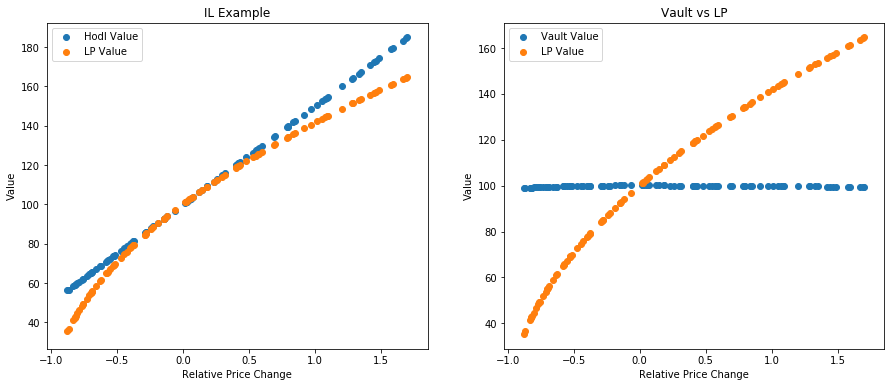

In [39]:
#IL Illuimport matplotlib.ticker as mtick
#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,6)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.set_ylabel('Value')
ax.set_xlabel('Relative Price Change')
plt.scatter(priceChangeLog, hodlValueLog, label = "Hodl Value")
plt.scatter(priceChangeLog, lpValueLog, label = "LP Value")
plt.legend(loc = 'upper left')
plt.title("IL Example")

#ax.scatter(priceChangeLog, drawdownLog)
#ax2.plot(debtRatioLog, color = 'orange', label = 'Debt Ratio')
#ax2.legend()

ax = fig.add_subplot(1, 2, 2)
ax.set_ylabel('Value')
ax.set_xlabel('Relative Price Change')
plt.scatter(priceChangeLog, vaultValueLog , label = "Vault Value")
plt.scatter(priceChangeLog, lpValueLog , label = "LP Value")
plt.legend(loc = 'upper left')
plt.title("Vault vs LP")


plt.show()


IL Example : This shows the value of holding a portfolio of 50% allocated to vault token & 50% secondary token performs given different price changes over 24h compared to entering those same assets into a liquidity pool. The more extreme the price movement in either positive or negative direction the higher the loss from IL. 

LP vs Vault Value : This shows how Robo Vault single assets vaule perform when entering 100% of portfolio in vaults compare to entering LP farm as above. This shows that the Vault Value stays roughly the same despite relative price movements in the secondary asset while the LP has more upside from increased value in the secondary asset but also signifiantly more downside. 

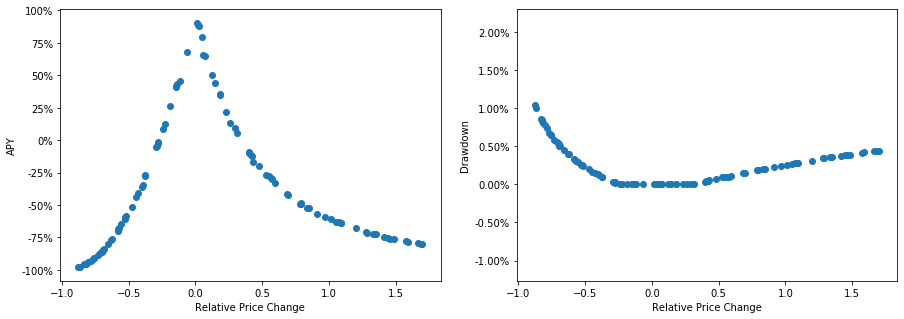

In [27]:
import matplotlib.ticker as mtick

#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.set_ylabel('APY')
ax.set_xlabel('Relative Price Change')
plt.scatter(priceChangeLog, apyLog)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


#ax.scatter(priceChangeLog, drawdownLog)
#ax2.plot(debtRatioLog, color = 'orange', label = 'Debt Ratio')
#ax2.legend()

ax = fig.add_subplot(1, 2, 2)
plt.scatter(priceChangeLog, drawdownLog)
ax.set_ylabel('Drawdown')
ax.set_xlabel('Relative Price Change')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()



To drilldown a bit more the above shows how extreme price movements over a 24h impact the APY of RoboVault vaults 

On the left we can see that the more extreme the price movements the worse RoboVaults perform with the APY going negative for very extreme measures.

To put these numbers into perspective the chart on the left shows the dradown on the vault with an ~-85% decrease in price over 24h leading to an approximate 1% drawdown. Showing that the vault is only likely to perform poorly in extreme market conditions while the vault can recover quickly as the marjority of the time price movements are likely not to be as extreme as -85% decrease over 24h. 

In [3]:
#SIM HELPERS
def setInitialValues() :
    vol1 = volume1
    vol2 = volume2 
    lp = createLp(vaultToken, secondaryToken, vol1, vol2)
    vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
    return vol1, vol2, lp, vaultInitial

def genSimulatedTrades() : 
    allTrades = []

    for i in range(nSteps) : 
        tradeStep = genTradesRandom(lambdaTrades, expScale, pBuy)
        allTrades.append(tradeStep)
    return allTrades

def simStats(vaultTVL, vaultLog) : 
    apy = (vaultLog[-1] / vaultTVL)**(stepsPerYear / nSteps) - 1
    dradown = 0
    prevMax = vaultTVL
    for i in range(len(vaultLog)) : 
        prevMax = max(prevMax, vaultLog[i])
        drawdownT = 1 - vaultLog[i] / prevMax
        drawdown = max(dradown, drawdownT)
    return apy, drawdown


In [4]:
# Simulate Price of Secondary Token CRASHING !!!

pBuy = .6 #high pBuy = more users buying vault Token and selling secondary token
lambdaTrades = 10 # input for poisson distribution to determine number of trades that occur in given time step
expScale = 100 # input for exponential distribution to determine size of trade 

allTrades = genSimulatedTrades()

vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog, priceLog, debtRatioLog, collatRatioLog, vol1, vol2 = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates)
vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog1, priceLog1, debtRatioLog1, collatRatioLog1, vol1, vol2 = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates, rebalance = False)

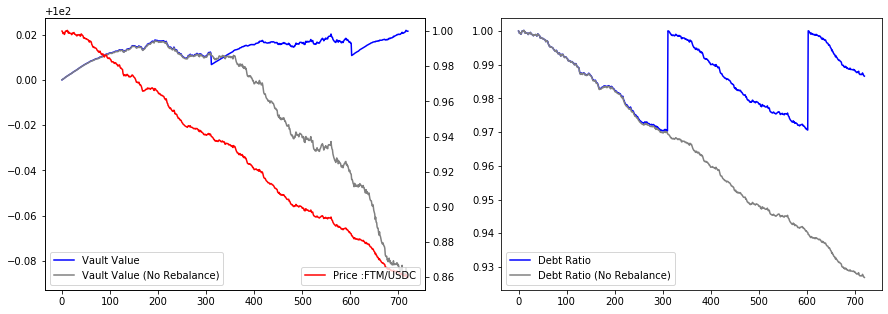

In [5]:
#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.plot(vaultLog, color = 'blue', label = 'Vault Value' )
ax.plot(vaultLog1, color = 'grey', label = 'Vault Value (No Rebalance)' )

ax.legend(loc = 'lower left')
ax2 = ax.twinx()
ax2.plot(priceLog, color = 'red', label = 'Price :' + secondaryToken + "/" + vaultToken)
#ax2.plot(debtRatioLog, color = 'orange', label = 'Debt Ratio')
ax2.legend(loc = 'lower right')

ax = fig.add_subplot(1, 2, 2)

ax.plot(debtRatioLog, color = 'blue', label = 'Debt Ratio' )
ax.plot(debtRatioLog1, color = 'grey', label = 'Debt Ratio (No Rebalance)' )
ax.legend(loc = 'lower left')

plt.show()


Example 1 - price of FTM / USDC crashes over 24
Showing how the vault is able to minimise the exposure to extreme price movements.

The chart on the left shows the Vault Value in two scenarios over a 24h period where the prices of the secondary token drop significantly. 
Scenario A) the vault rebalances  if the debt ratio falls above / below some thresholds
Scenario B) the vault does not rebalance  if the debt ratio  falls above / below some thresholds

This is because as prices fall users are selling the secondary token FTM for the vault token USDC meaning the ratio of FTM to USDC held in LP increases (reflecting the price fall) as prices continue to fall the value of LP in terms of USDC decreases  while the vaults debt value in terms of USDC also decreases due to IL the rate at which the lP decreases is larger than the decreased value of debt. The vault rebalancing mechanism aims to bring the vault back to a position where IL is minimised by borrowing additional FTM, swapping for USDC and adding back to LP for farming rewards. 

The chart on the right shows the debt ratio for both A) & B)

In [6]:
# Simulate Price of Secondary PUMPING !!!

pBuy = .4 #high pBuy = more users buying vault Token and selling secondary token
lambdaTrades = 10 # input for poisson distribution to determine number of trades that occur in given time step
expScale = 100 # input for exponential distribution to determine size of trade 

allTrades = genSimulatedTrades()

vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog, priceLog, debtRatioLog, collatRatioLog, vol1, vol2 = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates)
vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog1, priceLog1, debtRatioLog1, collatRatioLog1, vol1, vol2 = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates, rebalance = False)

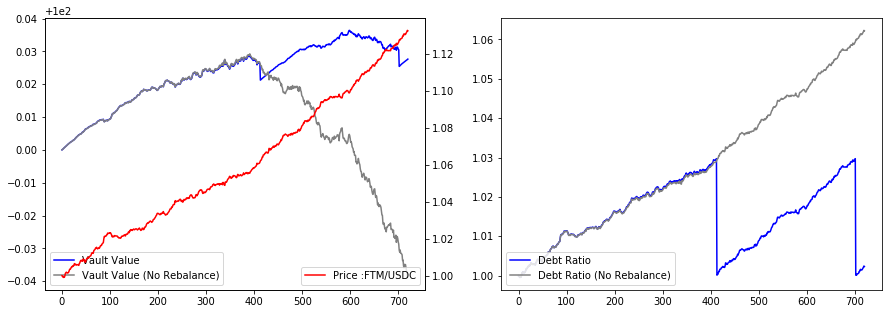

In [7]:
#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.plot(vaultLog, color = 'blue', label = 'Vault Value' )
ax.plot(vaultLog1, color = 'grey', label = 'Vault Value (No Rebalance)' )

ax.legend(loc = 'lower left')
ax2 = ax.twinx()
ax2.plot(priceLog, color = 'red', label = 'Price :' + secondaryToken + "/" + vaultToken)
#ax2.plot(debtRatioLog, color = 'orange', label = 'Debt Ratio')
ax2.legend(loc = 'lower right')

ax = fig.add_subplot(1, 2, 2)

ax.plot(debtRatioLog, color = 'blue', label = 'Debt Ratio' )
ax.plot(debtRatioLog1, color = 'grey', label = 'Debt Ratio (No Rebalance)' )
ax.legend(loc = 'lower left')

plt.show()


Example 2 - price of FTM / USDC pumps over 24

For similiar reasons as above increased prices = IL.

However in this case the debt ratio is increasing to > 100% as price increases in FTM / USDC means the value of the vaults debt in terms of USDC is increasing, while the LP value is also increasing it is doing so at a slower rate again a result of IL.

In this case rebalancing of the vault means removing some LP from farming, swapping the USDC from the removed LP and using this along with FTM removed from LP to repay debt. Again bring the vault back to a debt ratio of 100%, which is the poitn where IL is minimised. 